Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Training a 3D Diffusion Model for Generating 3D Images with Various Sizes and Spacings

![Generated image examples](https://developer-blogs.nvidia.com/wp-content/uploads/2024/06/image3.png)

In this notebook, we detail the procedure for training a 3D latent diffusion model to generate high-dimensional 3D medical images. Due to the potential for out-of-memory issues on most GPUs when generating large images (e.g., those with dimensions of 512 x 512 x 512 or greater), we have structured the training process into two primary steps: 1) generating image embeddings and 2) training 3D latent diffusion models. The subsequent sections will demonstrate the entire process using a simulated dataset.

`[Release Note (March 2025)]:` We are excited to announce the new MAISI Version `'maisi3d-rflow'`. Compared with the previous version `'maisi3d-ddpm'`, it accelerated latent diffusion model inference by 33x. Please see the detailed difference in the following section.

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"

## Setup imports

In [2]:
import copy
import os
import json
import numpy as np
import nibabel as nib
import subprocess
from IPython.display import Image, display

from monai.apps import download_url
from monai.data import create_test_image_3d
from monai.config import print_config

from scripts.diff_model_setting import setup_logging

print_config()

logger = setup_logging("notebook")

MONAI version: 1.4.1rc1+32.g34f37973
Numpy version: 1.26.4
Pytorch version: 2.5.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 34f379735c5e18e7f809453eb1b3606c225c788b
MONAI __file__: /localhome/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.20.0+cu124
tqdm version: 4.66.5
lmdb version: 1.5.1
psutil version: 6.1.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.17.1
pynrrd version: 1.0.0
clearml version: 1.16.5rc2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set up the MAISI version

Choose between `'maisi3d-ddpm'` and `'maisi3d-rflow'`. The differences are:
- The maisi version `'maisi3d-ddpm'` uses basic noise scheduler DDPM. `'maisi3d-rflow'` uses Rectified Flow scheduler, can be 33 times faster during inference.
- The maisi version `'maisi3d-ddpm'` requires training images to be labeled with body regions (`"top_region_index"` and `"bottom_region_index"`), while `'maisi3d-rflow'` does not have such requirement. In other words, it is easier to prepare training data for `'maisi3d-rflow'`.
- For the released model weights, `'maisi3d-rflow'` can generate images with better quality for head region and small output volumes, and comparable quality for other cases compared with `'maisi3d-ddpm'`.

In [3]:
maisi_version = "maisi3d-rflow"
if maisi_version == "maisi3d-ddpm":
    model_def_path = "./configs/config_maisi3d-ddpm.json"
elif maisi_version == "maisi3d-rflow":
    model_def_path = "./configs/config_maisi3d-rflow.json"
else:
    raise ValueError(f"maisi_version has to be chosen from ['maisi3d-ddpm', 'maisi3d-rflow'], yet got {maisi_version}.")
with open(model_def_path, "r") as f:
    model_def = json.load(f)
include_body_region = model_def["include_body_region"]
logger.info(f"MAISI version is {maisi_version}, whether to use body_region is {include_body_region}")

[2025-03-14 16:14:21.679][ INFO](notebook) - MAISI version is maisi3d-rflow, whether to use body_region is False


### Simulate a special dataset

It is widely recognized that training AI models is a time-intensive process. In this instance, we will simulate a small dataset and conduct training over multiple epochs. While the performance may not reach optimal levels due to the abbreviated training duration, the entire pipeline will be completed within minutes.

`sim_datalist` provides the information of the simulated datasets. It lists 2 training images. The size of the dimension is defined by the `sim_dim`.

In [4]:
sim_datalist = {"training": [{"image": "tr_image_001.nii.gz"}, {"image": "tr_image_002.nii.gz"}]}

sim_dim = (224, 224, 96)

### Generate simulated images

Now we can use MONAI `create_test_image_3d` and `nib.Nifti1Image` functions to generate the 3D simulated images under the `work_dir`.

In [5]:
work_dir = "./temp_work_dir"
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

dataroot_dir = os.path.join(work_dir, "sim_dataroot")
if not os.path.isdir(dataroot_dir):
    os.makedirs(dataroot_dir)

datalist_file = os.path.join(work_dir, "sim_datalist.json")
with open(datalist_file, "w") as f:
    json.dump(sim_datalist, f)

for d in sim_datalist["training"]:
    im, _ = create_test_image_3d(
        sim_dim[0], sim_dim[1], sim_dim[2], rad_max=10, num_seg_classes=1, random_state=np.random.RandomState(42)
    )
    image_fpath = os.path.join(dataroot_dir, d["image"])
    nib.save(nib.Nifti1Image(im, affine=np.eye(4)), image_fpath)

logger.info("Generated simulated images.")

[2025-03-14 16:14:22.301][ INFO](notebook) - Generated simulated images.


### Set up directories and configurations

To optimize the demonstration for time efficiency, we have adjusted the training epochs to 2. Additionally, we modified the `num_splits` parameter in [AutoencoderKlMaisi](https://github.com/Project-MONAI/MONAI/blob/dev/monai/apps/generation/maisi/networks/autoencoderkl_maisi.py#L881) from its default value of 16 to 4. This adjustment reduces the spatial splitting of feature maps in convolutions, which is particularly beneficial given the smaller input size. (This change helps convert convolutions to a for-loop based approach, thereby conserving GPU memory resources.)

In [6]:
env_config_path = "./configs/environment_maisi_diff_model.json"
model_config_path = "./configs/config_maisi_diff_model.json"

# Load environment configuration, model configuration and model definition
with open(env_config_path, "r") as f:
    env_config = json.load(f)

with open(model_config_path, "r") as f:
    model_config = json.load(f)

env_config_out = copy.deepcopy(env_config)
model_config_out = copy.deepcopy(model_config)
model_def_out = copy.deepcopy(model_def)

# Set up directories based on configurations
env_config_out["data_base_dir"] = dataroot_dir
env_config_out["embedding_base_dir"] = os.path.join(work_dir, env_config_out["embedding_base_dir"])
env_config_out["json_data_list"] = datalist_file
env_config_out["model_dir"] = os.path.join(work_dir, env_config_out["model_dir"])
env_config_out["output_dir"] = os.path.join(work_dir, env_config_out["output_dir"])
trained_autoencoder_path = os.path.join(work_dir, "models/autoencoder_epoch273.pt")
env_config_out["trained_autoencoder_path"] = trained_autoencoder_path
trained_autoencoder_path_url = (
    "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/"
    "model_zoo/model_maisi_autoencoder_epoch273_alternative.pt"
)
if not os.path.exists(trained_autoencoder_path):
    download_url(url=trained_autoencoder_path_url, filepath=trained_autoencoder_path)

# Create necessary directories
os.makedirs(env_config_out["embedding_base_dir"], exist_ok=True)
os.makedirs(env_config_out["model_dir"], exist_ok=True)
os.makedirs(env_config_out["output_dir"], exist_ok=True)

env_config_filepath = os.path.join(work_dir, "environment_maisi_diff_model.json")
with open(env_config_filepath, "w") as f:
    json.dump(env_config_out, f, sort_keys=True, indent=4)

# Update model configuration for demo
max_epochs = 2
model_config_out["diffusion_unet_train"]["n_epochs"] = max_epochs

model_config_filepath = os.path.join(work_dir, "config_maisi_diff_model.json")
with open(model_config_filepath, "w") as f:
    json.dump(model_config_out, f, sort_keys=True, indent=4)

# Update model definition for demo
model_def_out["autoencoder_def"]["num_splits"] = 2
model_def_filepath = os.path.join(work_dir, "config_maisi.json")
with open(model_def_filepath, "w") as f:
    json.dump(model_def_out, f, sort_keys=True, indent=4)

# Print files and folders under work_dir
logger.info(f"files and folders under work_dir: {os.listdir(work_dir)}.")

# Adjust based on the number of GPUs you want to use
num_gpus = 1
logger.info(f"number of GPUs: {num_gpus}.")

[2025-03-14 16:14:22.313][ INFO](notebook) - files and folders under work_dir: ['predictions', 'config_maisi.json', 'models', 'sim_dataroot', 'config_maisi_diff_model.json', 'embeddings', 'environment_maisi_diff_model.json', 'sim_datalist.json'].
[2025-03-14 16:14:22.314][ INFO](notebook) - number of GPUs: 1.


In [7]:
def run_torchrun(module, module_args, num_gpus=1):
    # Define the arguments for torchrun
    num_nodes = 1

    # Build the torchrun command
    torchrun_command = [
        "torchrun",
        "--nproc_per_node",
        str(num_gpus),
        "--nnodes",
        str(num_nodes),
        "-m",
        module,
    ] + module_args

    # Set the OMP_NUM_THREADS environment variable
    env = os.environ.copy()
    env["OMP_NUM_THREADS"] = "1"

    # Execute the command
    process = subprocess.Popen(torchrun_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, env=env)

    # Print the output in real-time
    try:
        while True:
            output = process.stdout.readline()
            if output == "" and process.poll() is not None:
                break
            if output:
                print(output.strip())
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        # Capture and print any remaining output
        stdout, stderr = process.communicate()
        print(stdout)
        if stderr:
            print(stderr)
    return

## Step 1: Create Training Data

To train the latent diffusion model, we first store the latent features produced by the autoencoder's encoder in local storage. This allows the latent diffusion model to directly utilize these features, thereby conserving both time and GPU memory during the training process. Additionally, we have provided the script for multi-GPU processing to save latent features from all training images, significantly accelerating the creation of the entire training set.

The diffusion model utilizes a U-shaped convolutional neural network architecture, requiring matching input and output dimensions. Therefore, it is advisable to resample the input image dimensions to be multiples of 2 for compatibility. In this case, we have chosen dimensions that are multiples of 128.

In [8]:
logger.info("Creating training data...")

# Define the arguments for torchrun
module = "scripts.diff_model_create_training_data"
module_args = [
    "--env_config",
    env_config_filepath,
    "--model_config",
    model_config_filepath,
    "--model_def",
    model_def_filepath,
    "--num_gpus",
    str(num_gpus),
]

run_torchrun(module, module_args, num_gpus=num_gpus)

[2025-03-14 16:14:22.326][ INFO](notebook) - Creating training data...



[2025-03-14 16:14:29.646][ INFO](creating training data) - Using device cuda:0
[2025-03-14 16:14:30.160][ INFO](creating training data) - filenames_raw: ['tr_image_001.nii.gz', 'tr_image_002.nii.gz']



### Create .json files for embedding files

The diffusion model necessitates additional input attributes, including output dimension, output spacing, and top/bottom body region. These dimensions and spacing can be extracted from the header information of the training images. The top and bottom body region inputs can be determined through manual examination or by utilizing segmentation masks from tools such as [TotalSegmentator](https://github.com/wasserth/TotalSegmentator) or [MONAI VISTA](https://github.com/Project-MONAI/VISTA). The body regions are formatted as 4-dimensional one-hot vectors: the head and neck region is represented by [1,0,0,0], the chest region by [0,1,0,0], the abdomen region by [0,0,1,0], and the lower body region (below the abdomen) by [0,0,0,1]. The additional input attributes are saved in a separate .json file. In the following example, we assume that the images cover the chest and abdomen regions.

In [9]:
def list_gz_files(folder_path):
    """List all .gz files in the folder and its subfolders."""
    gz_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".gz"):
                gz_files.append(os.path.join(root, file))
    return gz_files


def create_json_files(gz_files):
    """Create .json files for each .gz file with the specified keys and values."""
    for gz_file in gz_files:
        # Load the NIfTI image
        img = nib.load(gz_file)

        # Get the dimensions and spacing
        dimensions = img.shape
        dimensions = dimensions[:3]
        spacing = img.header.get_zooms()[:3]
        spacing = spacing[:3]
        spacing = [float(_item) for _item in spacing]

        # Create the dictionary with the specified keys and values
        data = {"dim": dimensions, "spacing": spacing}
        if include_body_region:
            # The region can be selected from one of four regions from top to bottom.
            # [1,0,0,0] is the head and neck, [0,1,0,0] is the chest region, [0,0,1,0]
            # is the abdomen region, and [0,0,0,1] is the lower body region.
            data["top_region_index"] = [0, 1, 0, 0]  # chest region
            data["bottom_region_index"] = [0, 0, 1, 0]  # abdomen region
        logger.info(f"data: {data}.")

        # Create the .json filename
        json_filename = gz_file + ".json"

        # Write the dictionary to the .json file
        with open(json_filename, "w") as json_file:
            json.dump(data, json_file, indent=4)
        logger.info(f"Save json file to {json_filename}")


folder_path = env_config_out["embedding_base_dir"]
gz_files = list_gz_files(folder_path)
create_json_files(gz_files)

logger.info("Completed creating .json files for all embedding files.")

[2025-03-14 16:14:32.560][ INFO](notebook) - data: {'dim': (64, 64, 32), 'spacing': [0.875, 0.875, 0.75]}.
[2025-03-14 16:14:32.562][ INFO](notebook) - Save json file to ./temp_work_dir/./embeddings/tr_image_001_emb.nii.gz.json
[2025-03-14 16:14:32.563][ INFO](notebook) - data: {'dim': (64, 64, 32), 'spacing': [0.875, 0.875, 0.75]}.
[2025-03-14 16:14:32.564][ INFO](notebook) - Save json file to ./temp_work_dir/./embeddings/tr_image_002_emb.nii.gz.json
[2025-03-14 16:14:32.565][ INFO](notebook) - Completed creating .json files for all embedding files.


## Step 2: Train the Model

After all latent features have been created, we will initiate the multi-GPU script to train the latent diffusion model.

The image generation process utilizes the [DDPM scheduler](https://arxiv.org/pdf/2006.11239) with 1,000 iterative steps. The diffusion model is optimized using L1 loss and a decayed learning rate scheduler. The batch size for this process is set to 1.

Please be aware that using the H100 GPU may occasionally result in random segmentation faults. To avoid this issue, you can disable AMP by setting the `--no_amp` flag.

In [10]:
logger.info("Training the model...")

# Define the arguments for torchrun
module = "scripts.diff_model_train"
module_args = [
    "--env_config",
    env_config_filepath,
    "--model_config",
    model_config_filepath,
    "--model_def",
    model_def_filepath,
    "--num_gpus",
    str(num_gpus),
]

run_torchrun(module, module_args, num_gpus=num_gpus)

[2025-03-14 16:14:32.570][ INFO](notebook) - Training the model...



[2025-03-14 16:14:39.869][ INFO](training) - Using cuda:0 of 1
[2025-03-14 16:14:39.869][ INFO](training) - [config] ckpt_folder -> ./temp_work_dir/./models.
[2025-03-14 16:14:39.869][ INFO](training) - [config] data_root -> ./temp_work_dir/./embeddings.
[2025-03-14 16:14:39.869][ INFO](training) - [config] data_list -> ./temp_work_dir/sim_datalist.json.
[2025-03-14 16:14:39.869][ INFO](training) - [config] lr -> 0.0001.
[2025-03-14 16:14:39.869][ INFO](training) - [config] num_epochs -> 2.
[2025-03-14 16:14:39.869][ INFO](training) - [config] num_train_timesteps -> 1000.
[2025-03-14 16:14:41.316][ INFO](training) - Training from scratch.
[2025-03-14 16:14:41.337][ INFO](training) - num_files_train: 2
[2025-03-14 16:14:41.634][ INFO](training) - Scaling factor set to 1.159693956375122.
[2025-03-14 16:14:41.634][ INFO](training) - scale_factor -> 1.159693956375122.
[2025-03-14 16:14:41.637][ INFO](training) - torch.set_float32_matmul_precision -> highest.
[2025-03-14 16:14:41.637][ INF

## Step 3: Infer using the Trained Model

Upon completing the training of the latent diffusion model, we can employ the multi-GPU script to perform inference. By integrating the diffusion model with the autoencoder's decoder, this process will generate 3D images with specified top/bottom body regions, spacing, and dimensions.

In [11]:
logger.info("Running inference...")

# Define the arguments for torchrun
module = "scripts.diff_model_infer"
module_args = [
    "--env_config",
    env_config_filepath,
    "--model_config",
    model_config_filepath,
    "--model_def",
    model_def_filepath,
    "--num_gpus",
    str(num_gpus),
]

run_torchrun(module, module_args, num_gpus=num_gpus)

logger.info("Completed all steps.")

[2025-03-14 16:14:49.136][ INFO](notebook) - Running inference...
[2025-03-14 16:15:02.647][ INFO](notebook) - Completed all steps.



[2025-03-14 16:14:56.275][ INFO](inference) - Using cuda:0 of 1 with random seed: 59473
[2025-03-14 16:14:56.275][ INFO](inference) - [config] ckpt_filepath -> ./temp_work_dir/./models/diff_unet_ckpt.pt.
[2025-03-14 16:14:56.275][ INFO](inference) - [config] random_seed -> 59473.
[2025-03-14 16:14:56.275][ INFO](inference) - [config] output_prefix -> unet_3d.
[2025-03-14 16:14:56.275][ INFO](inference) - [config] output_size -> (256, 256, 128).
[2025-03-14 16:14:56.275][ INFO](inference) - [config] out_spacing -> (1.0, 1.0, 0.75).
[2025-03-14 16:14:56.275][ INFO](root) - `controllable_anatomy_size` is not provided.
[2025-03-14 16:14:58.525][ INFO](inference) - checkpoints ./temp_work_dir/./models/diff_unet_ckpt.pt loaded.
[2025-03-14 16:14:58.527][ INFO](inference) - scale_factor -> 1.159693956375122.
[2025-03-14 16:14:58.528][ INFO](inference) - num_downsample_level -> 4, divisor -> 4.
[2025-03-14 16:14:58.536][ INFO](inference) - noise: cuda:0, torch.float32, <class 'torch.Tensor'>


Upon completing the full training with the actual CT datasets, users can expect output images similar to the examples below, which present the generated images in axial, sagittal, and coronal views. The specific content may vary depending on the distribution of body regions in the training set. It is advisable to use tools such as [ITK-SNAP](http://www.itksnap.org/pmwiki/pmwiki.php) or [3D Slicer](https://www.slicer.org/) to visualize the entire volume for a comprehensive evaluation, rather than relying solely on the three different views to assess the quality of the checkpoints.

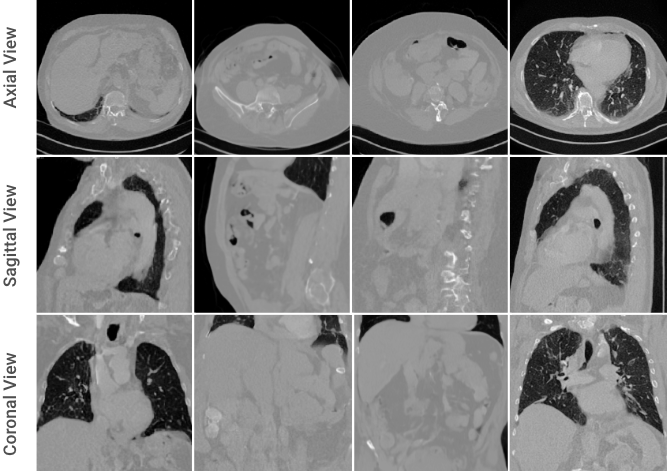

In [12]:
display(Image(filename="./figures/maisi_diff-train-examples.png"))